### Harbour Task - Elasticsearch Graph
###### 02/15/2021
***

* [Configuration, Vault and Elasticsearch Connections](#-)
* [Data Overview and Exploration](#--)
* [Elasticsearch Setup and Exploration](#---)
    * [Index our dataset records using bulk](#----)
    * [Simple Elasticsearch request to find top documents match a text query](#-----) 
* [Elasticsearch Graph In Kibana Exploration](#------) 
    * [Graph request body](#-------)
    * [Graph spidering reques](#--------)
* [Demo](#---------)


In [26]:
import configparser
import csv
import json
import logging
import time
import warnings
from collections import deque
import elasticsearch
import googlemaps
import hvac
import matplotlib.pyplot as plt
import pandas as pd
from elasticsearch import helpers
from elasticsearch.client.graph import GraphClient
from geotext import GeoText
from IPython.display import display
from ipywidgets import interact, widgets

warnings.filterwarnings("ignore")
logging.basicConfig(format="%(asctime)s %(name)s %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.propagate = True

###### -
## Configuration, Vault and Elasticsearch Connections
**Configuration File:** for the URLs, paths and ports and filenames <br>
**Vault:** to securly store the usernames and passwords

In [27]:
class Config:
    """
    Initialize the configurations vault and elasticsearch
    """

    VAULT_SECTION = "VAULT"
    ELASTIC_SECTION = "ELASTIC"
    DATA_SECTION = "DATA"

    INDEX_NAME = "contracts_index"
    TYPE = "contracts_docs"

    def __init__(self):
        self.config = configparser.ConfigParser()
        self.config.read("config/config.ini")
        logger.info("Vault, Elasticsearch, and Data Config loading...")
        if self.config.has_section(self.VAULT_SECTION):
            self.VAULT_ADDR = self.get_config(self.VAULT_SECTION, "VAULT_ADDR")
            self.USERNAME_PATH = self.get_config(self.VAULT_SECTION, "USERNAME_PATH")
            self.PASSWORD_PATH = self.get_config(self.VAULT_SECTION, "PASSWORD_PATH")
            self.GOOGLEMAPS_API = self.get_config(self.VAULT_SECTION, "GOOGLEMAPS_API")

        if self.config.has_section(self.ELASTIC_SECTION):
            self.ELASTIC_ADDR = self.get_config(self.ELASTIC_SECTION, "ELASTIC_ADDR")
            self.ELASTIC_PORT = self.get_config(self.ELASTIC_SECTION, "ELASTIC_PORT")

        if self.config.has_section(self.DATA_SECTION):
            self.CONTRACT_FILE = self.get_config(self.DATA_SECTION, "DATA_FILE")
            self.MAPPING_FILE = self.get_config(self.DATA_SECTION, "MAPPING_FILE")
        logger.info("Done.")

    def get_config(self, section, option):
        if self.config.has_option(section, option):
            return self.config.get(section, option)
        else:
            logger.warning(section + " " + option + " is returned None")
            return None

    def vault_connect(self):
            logger.info("Connecting to Vault...")
            self.vault_client = hvac.Client(url=self.VAULT_ADDR)
            is_auth = self.vault_client.is_authenticated()
            logger.info("Connected.") if is_auth else logger.error(
                "Vault Authonitcation Failed."
            )
            googlemaps_api_key = self.vault_client.secrets.kv.read_secret_version(
            path=self.GOOGLEMAPS_API
            )
            if googlemaps_api_key:
                self.googlemaps_api_key = googlemaps_api_key["data"]["data"]["apiKey"]


    def elasticsearch_connect(self):
        logger.info("Connecting to Elasticsearch...")
        try:
            username = self.vault_client.secrets.kv.read_secret_version(
                path=self.USERNAME_PATH
            )["data"]["data"]["username"]
            password = self.vault_client.secrets.kv.read_secret_version(
                path=self.PASSWORD_PATH
            )["data"]["data"]["password"]
            self.es_client = elasticsearch.Elasticsearch(
                [self.ELASTIC_ADDR],
                http_auth=(username, password),
                scheme="https",
                port=self.ELASTIC_PORT,
            )
            logger.info("Connected.")


        except:
            logger.error(
                "Elasticsearch connection failed, Please check credentials and config."
            )

In [28]:
config = Config()

2021-02-14 16:07:38,887 __main__ Vault, Elasticsearch, and Data Config loading...
2021-02-14 16:07:38,890 __main__ Done.


In [29]:
config.vault_connect()

2021-02-14 16:07:43,203 __main__ Connecting to Vault...
2021-02-14 16:07:43,218 __main__ Connected.


In [30]:
config.elasticsearch_connect()

2021-02-14 16:07:43,847 __main__ Connecting to Elasticsearch...
2021-02-14 16:07:43,861 __main__ Connected.


###### --
### Data Overview and Exploration 
**Dataset:** https://www.chicago.gov/city/en/dataset/contracts.html <br>
**Description:** Contracts and modifications awarded by the City of Chicago from 1993 to present.

In [31]:
class Data:
    """
    Load the dataset and explore it
    """

    def __init__(self, config, is_logging=True):
        self.dataset = pd.read_csv(config.CONTRACT_FILE)
        if is_logging:
            print("%s%s" % ("Total number of contracts = ", self.dataset.shape[0]))
            print("%s%s" % ("Total number of attributes = ", self.dataset.shape[1]))
            print("Contract attributes: ")
            print(json.dumps(list(self.dataset.columns.values), indent=2))

    def get_top_cities_by_contract_type(self, contract_type, count):
        res = self.dataset.loc[self.dataset["Contract Type"] == contract_type]
        return list(res.City.value_counts().index[:count])

    def get_states_by_num_of_contracts(self):
        states_count = self.dataset.State.value_counts()
        return states_count

    def get_contract_types_by_frequency(self):
        contract_types = self.dataset["Contract Type"].value_counts()
        soted_sum = [
            x for _, x in sorted(zip(contract_types.values, contract_types.index))
        ]
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.bar(soted_sum, sorted(contract_types.values))
        plt.xticks(fontsize=11, rotation="90")
        fig.suptitle('Number of contracts by contract type', fontsize=12)
        ax.set_xlabel('Contracts Type', fontsize=10)
        ax.set_ylabel('Number of Contracts', fontsize='medium')
        plt.show()

In [32]:
data = Data(config)

Total number of contracts = 51712
Total number of attributes = 19
Contract attributes: 
[
  "Purchase Order Description",
  "Purchase Order (Contract) Number",
  "Revision Number",
  "Specification Number",
  "Contract Type",
  "Start Date",
  "End Date",
  "Approval Date",
  "Department",
  "Vendor Name",
  "Vendor ID",
  "Address 1",
  "Address 2",
  "City",
  "State",
  "Zip",
  "Award Amount",
  "Procurement Type",
  "Contract PDF"
]


In [33]:
print("Top 4 Cities that have \'COMPTROLLER-OTHER\' contract type:")
data.get_top_cities_by_contract_type("COMPTROLLER-OTHER", 4)

Top 4 Cities that have 'COMPTROLLER-OTHER' contract type:


['CHICAGO', 'Chicago', 'KANSAS CITY', 'OAK PARK']

In [34]:
print("Get states by number of contracts:")
data.get_states_by_num_of_contracts()

Get states by number of contracts:


IL            48403
MO              319
TX              282
CA              260
WI              211
PA              210
NY              209
MI              170
IN              157
GA              146
MA              129
MD              109
FL              105
OH              101
MN               82
AZ               73
IA               67
NJ               64
VA               61
DC               58
CT               52
KY               49
CO               43
NC               36
TN               32
NE               30
WA               29
OR               23
LA               19
AL               17
CAN              17
NH               15
NV               14
RI               11
AR               10
SC               10
NM               10
OK               10
KS               10
DE                9
ID                6
UT                6
BC                4
SD                4
MS                4
WV                3
ME                3
ONTARIO           3
VT                2
MT                2


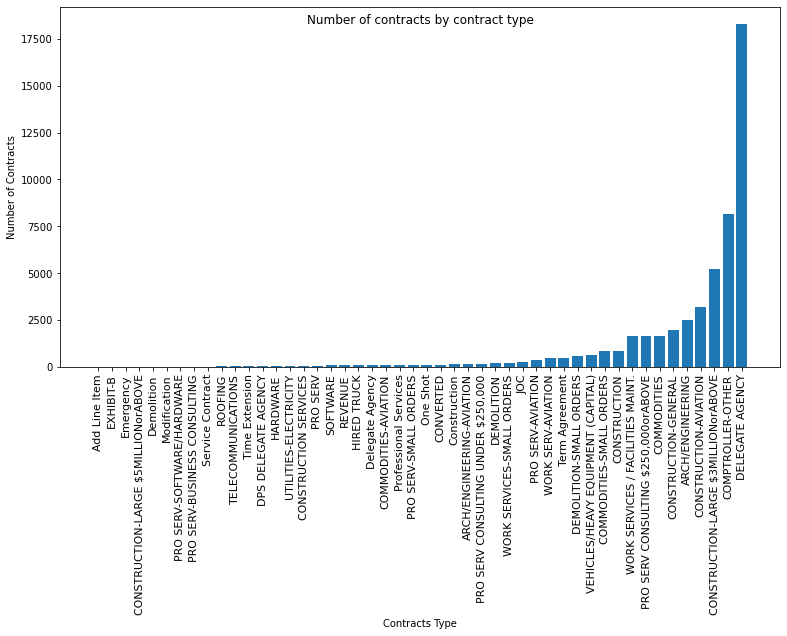

In [35]:
data.get_contract_types_by_frequency()

###### ---
### Elasticsearch Setup and Exploration

In [36]:
class Contracts_Elasticsearch:
    """
    Create index, generate query and search documents
    """

    def __init__(self, config):
        self.INDEX_NAME = config.INDEX_NAME
        self.MAPPING_FILE = config.MAPPING_FILE
        self.CONTRACT_FILE = config.CONTRACT_FILE
        self.TYPE = config.TYPE

        self.es_client = config.es_client

    def generate_request_body(self, search_terms=None, best_terms=None, best_fields=None):
        body = {}
        body["sort"] = [{"_score": {"order": "desc"}}]
        body["query"] = {}
        if best_terms and best_fields:
            boolq = {}
            body["query"]["bool"] = boolq
            body["query"]["bool"]["filter"] = []
            for bt in range(len(best_terms)):
                condition = {}
                condition["bool"] = {}
                condition["bool"]["should"] = []
                condition_details = {}
                condition_details["match_phrase"] = {}
                condition_details["match_phrase"][best_fields[bt]] = best_terms[bt]
                condition["bool"]["should"].append(condition_details)
                body["query"]["bool"]["filter"].append(condition)
            if search_terms:
                for st in search_terms:
                    condition = {}
                    condition["multi_match"] = {}
                    condition["multi_match"]["type"] = "phrase"
                    condition["multi_match"]["query"] = st
                    condition["multi_match"]["lenient"] = True
                    body["query"]["bool"]["filter"].append(condition)
        else:
            for st in search_terms:
                body["query"]["multi_match"] = {}
                body["query"]["multi_match"]["type"] = "phrase"
                body["query"]["multi_match"]["query"] = st
                body["query"]["multi_match"]["lenient"] = True

        return body

    def create_index(self):
        try:
            logger.info("Elasticsearch Indexing Started...")
            start = time.time()
            with open(self.CONTRACT_FILE, "r+", encoding="utf-8") as f:
                reader = csv.DictReader(f)
                index = 0
                self.es_client.indices.delete(index=self.INDEX_NAME, ignore=[400, 404])
                self.es_client.indices.create(index=self.INDEX_NAME, ignore=400)
                self.es_client.indices.put_mapping(
                    index=self.INDEX_NAME,
                    doc_type=self.TYPE,
                    ignore=400,
                    body=open(self.MAPPING_FILE, "r").read(),
                )
                response = helpers.bulk(self.es_client, reader, index=self.INDEX_NAME, doc_type=self.TYPE)
                self.es_client.indices.refresh()
                print(response)
            f.close()
            end = time.time()
            logger.info("Elapsed Time: " + str(round(end - start, 2)) + "s")
            logger.info("(" + str(response[0]) + ")" + " documents indexted to Elasticsearch")
        except:
            logger.error("Error while indexing.")

    def es_search(self, request_body, query="the requested query", is_total=False):
        try:
            if is_total:
                res = self.es_client.search(index=self.INDEX_NAME, body=request_body, scroll="2m")
            else:
                res = self.es_client.search(index=self.INDEX_NAME, body=request_body)
            results = res["hits"]["hits"]
            logger.info('Total results with "' + query + '" ' + str(len(results)))
            return results
        except:
            logger.error("Error while state searching.")
        return []

###### ----
#### 1- Index our dataset records using bulk

In [37]:
contracts_es = Contracts_Elasticsearch(config)
# contracts_es.create_index()

###### -----
#### 2- Simple Elasticsearch request to find top documents match a text query
The rsults are stored by score descending, the score in elasticsearch is **tf-idf** term frequency–inverse document frequency.<br>
**termFreq:** The number of times the term appears in the field of a document.<br>
**maxDocs:** documents in the index<br>
**docFreq:** number of documents contain the term<br>
**normalize** the results so we can compare all the search queries
$$tf= \sqrt termFreq $$
$$idf = 1+ \log \frac{maxDocs}{docFreq + 1}$$
$$norm = \frac{1}{\sqrt numFieldTerms}$$
$$score = tf * idf * norm$$

In [38]:
query = ["New South Loop Elementary School IGA with CPS"]
request_body = contracts_es.generate_request_body(query)
res = contracts_es.es_search(request_body, query[0], is_total=True)
res = contracts_es.es_search(request_body, query[0], is_total=False)
print(json.dumps(res[0], indent=2))

2021-02-14 16:07:58,527 __main__ Total results with "New South Loop Elementary School IGA with CPS" 4
2021-02-14 16:07:58,565 __main__ Total results with "New South Loop Elementary School IGA with CPS" 4


{
  "_index": "contracts_index",
  "_type": "contracts_docs",
  "_id": "BKU1l3cBuwdZgPN-qiR3",
  "_score": 40.61244,
  "_source": {
    "Purchase Order Description": "New South Loop Elementary School IGA with CPS",
    "Purchase Order (Contract) Number": "53736",
    "Revision Number": "2",
    "Specification Number": "393134",
    "Contract Type": "COMPTROLLER-OTHER",
    "Start Date": "12/1/16",
    "End Date": "7/30/21",
    "Approval Date": "10/26/17",
    "Department": "OFFICE OF BUDGET & MANAGEMENT",
    "Vendor Name": "BOARD OF EDUCATION OF THE CITY OF CHICAGO",
    "Vendor ID": "102692356V",
    "Address 1": "42 W MADISON ST",
    "Address 2": "",
    "City": "CHICAGO",
    "State": "IL",
    "Zip": "60602",
    "Award Amount": "-37666000",
    "Procurement Type": "",
    "Contract PDF": "http://ecm.cityofchicago.org/eSMARTContracts/service/DPSWebDocumentViewer?sid=ESMART&id={E4AB4B96-D6FE-4A03-9E48-9ADC1F7D8D2F}"
  }
}


###### ------
### Elasticsearch Graph In Kibana Exploration

In [39]:
class Elasticsearch_Graph:
    """
    Explore elasticsearch graph
    """

    def __init__(self, config):
        self.INDEX_NAME = config.INDEX_NAME
        self.MAPPING_FILE = config.MAPPING_FILE
        self.CONTRACT_FILE = config.CONTRACT_FILE
        self.TYPE = config.TYPE

        self.es_client = config.es_client

    def generagte_request_body(
        self,
        fields,
        connections,
        multi_match_type,
        certainty,
        sample_size,
        timeout,
        query_terms=None,
        include=None,
        execlude=None,
        is_spider=False,
    ):
        request_body = {}
        if not is_spider:
            request_body["query"] = {}
            request_body["query"]["bool"] = {}
            request_body["query"]["bool"]["should"] = []
            if query_terms is not None:
                for term in query_terms:
                    filters = {}
                    filters["bool"] = {}
                    filters["bool"]["filter"] = []
                    for t in term:
                        multi_match = {}
                        multi_match["multi_match"] = {}
                        multi_match["multi_match"]["type"] = multi_match_type
                        multi_match["multi_match"]["query"] = t
                        multi_match["multi_match"]["lenient"] = True
                        filters["bool"]["filter"].append(multi_match)
                    request_body["query"]["bool"]["should"].append(filters)
        request_body["controls"] = {}
        request_body["controls"]["use_significance"] = True
        request_body["controls"]["sample_size"] = sample_size
        request_body["controls"]["timeout"] = timeout
        request_body["connections"] = {}
        request_body["connections"]["vertices"] = []
        request_body["vertices"] = []
        for field in fields:
            vertex = {}
            vertex["field"] = field
            vertex["size"] = 5
            vertex["min_doc_count"] = certainty
            if include:
                vertex["include"] = include
            request_body["vertices"].append(vertex)
        for c in range(len(connections)):
            connection = {}
            connection["field"] = connections[c]
            connection["size"] = 5
            connection["min_doc_count"] = certainty
            if execlude:
                connection["exclude"] = execlude[c]
            request_body["connections"]["vertices"].append(connection)
        return request_body

    def create_graph_in_kibana(self, request_body, is_sort=True):
        graph_client = GraphClient(self.es_client)
        res = graph_client.explore(index=self.INDEX_NAME, body=request_body)

        vertices = res["vertices"]
        connections = res["connections"]
        vertices_values = []
        fields_values = []

        connections = (
            sorted(res["connections"], key=lambda k: k["weight"], reverse=True)
            if is_sort
            else res["connections"]
        )

        for v in vertices:
            vertices_values.append(v["term"])
            fields_values.append(v["field"])

        for c in connections:
            c["source"] = [vertices_values[c["source"]], fields_values[c["source"]]]
            c["target"] = [vertices_values[c["target"]], fields_values[c["target"]]]

        return connections

###### -------
#### 1. Graph request body
<br>To start Graph Exploration I followed the following :
<ol>
<li>Prepare the query:
    <ol>
        <li>Define the elasticsearch index </li>
        <li>Choose the Vertices: Choose the fields (columns in dataset terms) that we want to use as vertices in the graph</li>
        <li>Choose the Connections: the fields from which we want to extract term that are associated with the specified vertices.<ol>For each field we choose to be a vertex or in the connection we define:
                <li>Define the size: maximum number of vertex terms returned for each field</li>
                <li>Define min_doc_count: specifies how many documents must contain a pair of terms before it is considered to be a useful connection</li></ol>
        </li>            
        <li>Prepare the search term from which we are interested to see the related vertices </li>
        <li>Define the sample size, Each hop considers a sample of the best-matching documents</li>
    </ol>
</li>
<li>The weight in the response specifies the significance score
    </li>
<li>The depth attribute specifies the hop-level</li>
<li>The doc_count value indicates how many documents in the sample set contain this pairing of terms</li>
</ol>

[Elasticsearch significance score](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-significantterms-aggregation.html#search-aggregations-bucket-significantterms-aggregation).

In [40]:
es_gragh = Elasticsearch_Graph(config)

In [41]:
query_terms = [["New South Loop Elementary School IGA with CPS"]]
multi_match_types = ["phrase", "best_fields", "most_fields", "cross_fields"]
fields = ["Contract Type.keyword", "Vendor Name.keyword"]
connections = ["Contract Type.keyword", "Vendor Name.keyword"]
request_body = es_gragh.generagte_request_body(
    fields, connections, multi_match_types[0], 3, 2000, 5000, query_terms
)

In [42]:
# print(json.dumps(query, indent=2))
connections = es_gragh.create_graph_in_kibana(request_body, True)
connections

[{'source': ['BOARD OF EDUCATION OF THE CITY OF CHICAGO',
   'Vendor Name.keyword'],
  'target': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'weight': 0.6371781093215246,
  'doc_count': 111},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['BOARD OF EDUCATION OF THE CITY OF CHICAGO',
   'Vendor Name.keyword'],
  'weight': 0.0035757113284619717,
  'doc_count': 111},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['CHICAGO PARK DISTRICT', 'Vendor Name.keyword'],
  'weight': 0.0007399264863569791,
  'doc_count': 57},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['CARDINAL HEALTH', 'Vendor Name.keyword'],
  'weight': 0.0002036985333051037,
  'doc_count': 7},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['PUBLIC BUILDING COMMISSION CHICAGO', 'Vendor Name.keyword'],
  'weight': 0.0001599122742157049,
  'doc_count': 14},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  't

![title](imgs/graph_1.png)

In [43]:
best_term1 = connections[0]["source"][0]
best_field1 = connections[0]["source"][1]
best_term2 = connections[0]["target"][0]
best_field2 = connections[0]["target"][1]
best_terms = [best_term1, best_term2]
best_fields = [best_field1, best_field2]
search_terms = ["New South Loop Elementary School IGA with CPS"]
es_request_body = contracts_es.generate_request_body(
    search_terms, best_terms, best_fields
)

In [44]:
res = contracts_es.es_search(es_request_body, is_total=False)
res

2021-02-14 16:08:08,456 __main__ Total results with "the requested query" 4


[{'_index': 'contracts_index',
  '_type': 'contracts_docs',
  '_id': 'baU1l3cBuwdZgPN-ty1p',
  '_score': 0.0,
  '_source': {'Purchase Order Description': 'New South Loop Elementary School IGA with CPS',
   'Purchase Order (Contract) Number': '53736',
   'Revision Number': '0',
   'Specification Number': '393134',
   'Contract Type': 'COMPTROLLER-OTHER',
   'Start Date': '12/1/16',
   'End Date': '7/30/20',
   'Approval Date': '2/15/17',
   'Department': 'OFFICE OF BUDGET & MANAGEMENT',
   'Vendor Name': 'BOARD OF EDUCATION OF THE CITY OF CHICAGO',
   'Vendor ID': '102692356V',
   'Address 1': '42 W MADISON ST',
   'Address 2': '',
   'City': 'CHICAGO',
   'State': 'IL',
   'Zip': '60602',
   'Award Amount': '10667000',
   'Procurement Type': '',
   'Contract PDF': 'http://ecm.cityofchicago.org/eSMARTContracts/service/DPSWebDocumentViewer?sid=ESMART&id={CDF5B82B-2059-436A-88D5-98CC7DBF415B}'}},
 {'_index': 'contracts_index',
  '_type': 'contracts_docs',
  '_id': 'BKU1l3cBuwdZgPN-qiR3',



###### --------
#### 2. Elasticsearch Graph Spidering Operation
After an initial search, if we want to select vertices of interest and see what additional vertices are connected. we operate expanding or what called spridering
to start this operation we need :
<ol>
    <li>The set of vertices for which we want to find additional connections</li>
    <li>The set of vertices you already know about that we want to exclude from the results of the spidering operation.</li>
</ol>



In [45]:
multi_match_types = ["phrase", "best_fields", "most_fields", "cross_fields"]
fields = ["Contract Type.keyword"]
connections = ["Contract Type.keyword", "Vendor Name.keyword"]
fields_include = [{"term": "COMPTROLLER-OTHER"}]
connections_execlude = [
    ["COMPTROLLER-OTHER"],
    [
        "CHICAGO PARK DISTRICT",
        "BOARD OF EDUCATION OF THE CITY OF CHICAGO",
        "KASIA'S DELI INC",
        "PUBLIC BUILDING COMMISSION CHICAGO",
        "CARDINAL HEALTH",
    ],
]
spider_request_body = es_gragh.generagte_request_body(
    fields,
    connections,
    multi_match_types[0],
    3,
    2000,
    5000,
    None,
    fields_include,
    connections_execlude,
    True,
)
# print(json.dumps(query, indent=2))

In [46]:
res = es_gragh.create_graph_in_kibana(spider_request_body)
res

[{'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['FEDERAL AVIATION ADMINISTRATION', 'Vendor Name.keyword'],
  'weight': 0.22523017657694652,
  'doc_count': 22},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['BILLY GOAT TAVERN & GRILL', 'Vendor Name.keyword'],
  'weight': 0.2029531184057598,
  'doc_count': 9},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['NNAMDI AFRICAN ORIGINS', 'Vendor Name.keyword'],
  'weight': 0.17613045142498274,
  'doc_count': 4},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['CONGO SQUARE THEATRE COMPANY', 'Vendor Name.keyword'],
  'weight': 0.17613045142498274,
  'doc_count': 4},
 {'source': ['COMPTROLLER-OTHER', 'Contract Type.keyword'],
  'target': ['POLO CAFE & CATERING BRIDGEPORT U.S.A.', 'Vendor Name.keyword'],
  'weight': 0.16955580216732824,
  'doc_count': 5}]

![title](imgs/graph_2.png)

###### ---------
### Demo

In [47]:
class Search:
    def __init__(self, config, es_graph, es, threshold):
        self.config = config
        self.es_client = config.es_client
        self.es_graph = es_graph
        self.es = es
        self.threshold = threshold

    def es_search(self, connections):
        count = 0
        ress = []
        reasons = []
        while len(ress) < 20 and count < len(connections):
            if connections[count]["weight"] > self.threshold:
                reasons.append(connections[count]["weight"])
                reasons.append(connections[count]["doc_count"])
                best_term1 = connections[count]["source"][0]
                best_field1 = connections[count]["source"][1]
                best_term2 = connections[count]["target"][0]
                best_field2 = connections[count]["target"][1]
                best_terms = [best_term1, best_term2]
                best_fields = [best_field1, best_field2]
                request_body = self.es.generate_request_body(
                    None, best_terms, best_fields
                )
                res = self.es.es_search(request_body, is_total=True)
                ress = ress + res
            count += 1
        return ress

    def graph_search(self, cities_text, states_text):
        query_terms = [cities_text, states_text]
        multi_match_types = ["phrase", "best_fields", "most_fields", "cross_fields"]
        fields = ["Contract Type.keyword", "Vendor Name.keyword"]
        connections = ["Contract Type.keyword", "Vendor Name.keyword"]
        request_body = self.es_graph.generagte_request_body(
            fields, connections, multi_match_types[0], 1, 2000, 5000, query_terms
        )
        connections = self.es_graph.create_graph_in_kibana(request_body)
        res = self.es_search(connections)

        return res

    def get_city_state(self, city):
        gmaps = googlemaps.Client(key=self.config.googlemaps_api_key)
        result = gmaps.geocode(city)
        state = result[0]["formatted_address"].split(", ")[1]
        return state

    def search(self, search_query):
        states = []
        cities = []
        text = []
        terms = search_query.split(" ")
        for term in terms:
            places = GeoText(term.title())
            if places.cities:
                city = places.cities[0]
                cities.append(city)
                state = self.get_city_state(city)
                states.append(state)
            else:
                text.append(term)
        cities_text = cities + text
        states_text = states + text
        res = self.graph_search(cities_text, states_text)
        return res

In [48]:
def start(term):
    config = Config()
    config.vault_connect()
    config.elasticsearch_connect()
    config.es_client
    es = Contracts_Elasticsearch(config)
    es_graph = Elasticsearch_Graph(config)
    search_client = Search(config, es_graph, es, .0001)
    res = search_client.search(term)
    return res

In [49]:
print("This search will be done using Elasticsearch graph and Elasticsearch")
text = widgets.Text(
    value="", placeholder="Press Enter to Search", description="Query:", disabled=False
)
output = widgets.Output()
display(text, output)


def callback(wdgt):
    # replace by something useful
    start_time = time.time()
    output_str = ""
    with output:
        logger.propagate = False
        search_results = start(wdgt.value)
        end_time = time.time()
        print("Elapsed Time: " + str(round(end_time - start_time, 2)) + "s")
        # print("Total Results: " + print(len(search_results)))
        for i in search_results:
            output_str += (
                "Purchase Order Description: "
                + i["_source"]["Purchase Order Description"]
                + "\n"
                + "Vendor Name: "
                + i["_source"]["Vendor Name"]
                + "\n"
                + "Contract Typen: "
                + i["_source"]["Contract Type"]
                + "\n"
                + "Contract PDF: "
                + i["_source"]["Contract PDF"]
                + "\n"
                + "City: "
                + i["_source"]["City"]
                + "\n"
                + "State: "
                + i["_source"]["State"]
                + "\n"
                + ""
                + "_____________________ \n"
            )
        print(output_str)
text.on_submit(callback)

This search will be done using Elasticsearch graph and Elasticsearch


Text(value='', description='Query:', placeholder='Press Enter to Search')

Output()

![title](imgs/results.png)